## Conformal Prediction 
Conformal prediction is a hot field of research.  It has garnered much attention due to its flexibility and the accompanying theoretical guarantees.  However, one must pay close attention to truly understand the nature of these guarantees.  In many cases, their practical utility is less than one might imagine.

We will start by covering the basics behind the theory of conformal prediction, with a focus on "split" conformal prediction.  We will then demonstrate Conformalized Quantile Regression (CQR), which overcomes many of the drawbacks of the standard alternatives.  We will use the MAPIE package and explain what is going on "under the hood".

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


## Theory behind Conformal Prediction
### Thought Experiment
Suppose I have variables $Z_1,Z_2$ which are iid draws from some (continuous) distribution. (So, $P(Z_1 = Z_2) = 0$)

What is $P(Z_2>Z_1)$?  What is $P(Z_2<Z_1)$?

<br>



Now suppose I have $Z_1, Z_2, Z_3$ iid variables.

What is $P(Z_3<\min(Z_1, Z_2))$?
What is $P(Z_3>\max(Z_1, Z_2))$?  

What is $P(\min(Z_1, Z_2) < Z_3 < \max(Z_1, Z_2))$?

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

### This generalizes...
If I have $Z_1, Z_2, \ldots, Z_{n+1}$ iid from any (continuous) distribution, then $Z_{n+1}$ is equally likely to be in any of the $(n+1)$ "bins" created by ordering $Z_1, \ldots, Z_n$ from smallest to largest.

In other words:
- let $A_1$ be the smallest of $Z_1, Z_2, \ldots, Z_n$
- $A_2$ be second smallest, etc. 
- up to $A_n$ the largest.  

Then $Z_{n+1}$ is equally likely to be in any of the $(n+1)$ intervals:

$(-\infty, A_1), (A_1, A_2), \ldots, (A_{n-1}, A_n), (A_n, \infty)$

so we can conclude:

$P(Z_{n+1} < A_k) = \frac{k}{n+1}$

(Could say something similar with discrete distributions, but gets more complicated with ties, etc... and have to be careful about $<, \leq, =$)

<br>
<br>
<br>


### Example
Let $n=9$, I have 10 observations from some iid distribution $Z_1, Z_2, \ldots, Z_{10}$:

Let $A_8$ be the eight biggest one out of the first 9.

$P(X_{10} < A_8) = .8$

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


## KEY CAVEAT
This is only true when we have *unconditional* probabilities:
- i.e. BEFORE we know the values of any of the variables.  
- Once I *know* the values $Z_1=3, Z_2=10, Z_3=3.001$, it is no longer true that $X_4$ is equally likely to be in each of the defined intervals.

(This can bend your mind a little bit, but is the key to properly understanding the "guarantees" of conformal prediction)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


### Approach to Split Conformal Prediction (SCP)
1) You get a training set $S_{tr} = (X_i, Y_i)$ from the probability distribution $P(X,Y)$ and build your model $M$ on it (assume $Y$ is numeric, continuous).  So now $M$ maps an "$X$ value" to a "$Y$ value".
2) You get a calibration set $S_{ca} = (X_i, Y_i)$ from the same probability distribution. Let $z_i$ be the set of *calibration residuals* => $Z_i = |M(X_i) - Y_i|$ for the $(X_i, Y_i)$ in $S_{ca}$. Let $n$ be the size of the calibration set.
3) These $Z_i$, $i=1,\ldots,n$ will serve the same role of "dividing up" $[0, \infty)$  into intervals.  Let $A_1$ be the smallest, $A_2$ be the second smallest, etc.
4) Generate a new point $(X_0, Y_0)$ from $P(X,Y)$ and let $Z_0 = |M(X_0) - Y_i|$ (e.g. a point in the test set).  Let $Z_0 = |M(X_0) - Y_i|$ (the residual of this new point).  Suppose $n=99$ and we want 80\% "coverage" for a prediction interval.  We know from before that:

$P(Z_0 < A_{80})=.8$

$P(|M(X_0)-Y_0| < A_{80}) =.8$

$P(Y_0 - A_{80} < M(X_0) < Y_0 + A_{80}) = .8$

Put another way, 80\% of the time, your model prediction is within $A_{80}$ of the true answer, where $A_{80}$ is the 80th biggest error (out of 99) in your calibration set!

Roughly speaking: Suppose $A_{80} = 12$.  Since in the past, 80\% of your errors were less than 12, we can just add +/- 12 to (all) our predictions and the corresponding interval will contain the right answer 80\% of the time!

And it works for any model $M$, no matter how you created it!

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


#### Q: This sounds too good to be true!  What am I missing?

The key caveat, is that this is "on average" across all $X$ values.  Specifically, we are using the same +/- value regardless of the value of $X$.  Mathematically speaking, the coverage is **not conditional on $X=x$**

#### Q: Why does that matter?

Suppose you have a house price prediction model.  Houses range in price from \\$100,000 to \\$20,000,000.  You use split conformal prediction to get 90\% coverage and it gives you a +/- value of \\$90,000.  What will happen in practice?

For a point prediction of 80,000 your prediction interval will be (-10K, 170K)

For a point prediction of 15,000,000 your prediction interval will be (14.91M, 15.09M)

Do you think you will have the same 90\% coverage on both shacks and mansions?

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


### Additional Limitations
Suppose your model makes predictions of \\$300,000 on two different condos.  For condo 1, many nearby condos have been sold between \\$295,000 and \\$305,000. For condo 2, similar units have been sold from \\$200,000 to \\$400,000.  

Will SCP adapt its intervals to reflect higher confidence in condo 1?  No!  SCP only looks at the point prediction of the model, and the residuals across the entire calibration set (ignoring the effect of $X$ on the residuals).  It cannot learn the confidence from the data set (the way the probabilistic regression methods do).

That said, Split Conformal Prediction is a simple way to get prediction intervals that (on average across all X values) give the desired coverage (and can be proven to do so).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgbm
from sklearn.base import RegressorMixin, clone

In [2]:
random_state = 42

In [3]:
# Load in data set and clean up the column names
df_concrete = pd.read_csv("concr_mod.csv")
df_concrete.columns = ['cement', 'blast_furnace_slag', 'fly_ash', 'water', 'superplasticizer', 'coarse_agg', 'fine_agg', 'age_days','strength']

In [4]:
np.random.seed(random_state)
foldnum = np.random.randint(0,10,df_concrete.shape[0])
pd.Series(foldnum).value_counts()

0    122
2    112
4    111
9    110
7    104
5    100
6     97
3     97
8     94
1     83
dtype: int64

In [5]:
# 50% train, 20% valid, 30% test
dfc_train = df_concrete[foldnum<=4]
dfc_valid = df_concrete[(foldnum>4) & (foldnum<=6)]
dfc_test = df_concrete[foldnum>6]

dfc_train_val = pd.concat((dfc_train, dfc_valid))

In [6]:
features = df_concrete.columns[:-1].tolist()
target = 'strength'
X_train = dfc_train.loc[:,features]
y_train = dfc_train[target].to_numpy()

X_calib = dfc_valid.loc[:,features]
y_calib = dfc_valid[target].to_numpy()

X_test = dfc_test.loc[:,features]
y_test = dfc_test[target].to_numpy()

X_train_val = dfc_train_val.loc[:,features]
y_train_val = dfc_train_val[target].to_numpy()


In [7]:
lgbm1 = lgbm.LGBMRegressor(
    max_depth=8, n_estimators=5000, learning_rate=.02,
    random_state=random_state
)

In [8]:
lgbm1.fit(X_train, y_train, eval_set=[(X_calib, y_calib)],
                          callbacks=[lgbm.early_stopping(stopping_rounds=50)])

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1452]	valid_0's l2: 24.0151


LGBMRegressor(learning_rate=0.02, max_depth=8, n_estimators=5000,
              random_state=42)

In [9]:
calib_preds = lgbm1.predict(X_calib)
calib_preds[:4]

array([61.92434573, 41.85444659, 40.02465142, 45.24391462])

In [10]:
num_pts_calib = len(y_calib)
q_val=.8
resids = np.abs(y_calib-calib_preds)
sorted_resids = np.sort(resids)

Recall, if we had 99 points, we want to use the 80th largest one (which means index 79 in python).

Three sources of confusion:
- $n$ vs $n+1$ (points vs intervals)
- rounding up (to be conservative)
- the pythonic 0-indexing

Generally, for n points, we want the following calculation:

$q * ((n+1)/ n) * n$ (rounded up) gives us the order statistic we want.


In [11]:
index_to_use = int(np.ceil(q_val * (num_pts_calib +1))-1)
adj = sorted_resids[index_to_use]
num_pts_calib, index_to_use, adj

(197, 158, 5.9525390262841)

Let's try it out...

In [12]:
point_preds_test = lgbm1.predict(X_test)

In [13]:
left_ep_scp = point_preds_test - adj
right_ep_scp = point_preds_test + adj

In [14]:
pis_test_scp = np.vstack((left_ep_scp, right_ep_scp)).T
pis_test_scp[:4,:]

array([[35.09485222, 46.99993027],
       [41.60997457, 53.51505262],
       [37.65223732, 49.55731537],
       [25.37784611, 37.28292416]])

In [15]:
coverage_res_scp = (y_test >= pis_test_scp[:,0]) & (y_test<=pis_test_scp[:,1])
np.mean(coverage_res_scp), np.mean(pis_test_scp[:,1]-pis_test_scp[:,0])

(0.814935064935065, 11.9050780525682)

We get the desired coverage, but below we see that this is not uniform

In [16]:
np.mean(coverage_res_scp[y_test<20]), np.mean(coverage_res_scp[y_test>=60])

(0.9230769230769231, 0.6296296296296297)

## **Q**: Is there any flavor of Conformal Prediction that can address these limitations?

## **A**: Yes!  Enter Conformal Quantile Regression (CQR)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Background on Quantile Regression
Quantile Regression is a problem where you want to predict the quantile of a distribution.

For example, you want to predict the .1 (10\%) quantile, that means that you want to be "too high" 10\% of the time and "too low" 90\% of the time.

In machine learning, this would be done by using a loss function:

$L(y_t, y_p) = \max\{.1(y_p - y_t) + .9(y_t-y_p)\}$

More generally, for $\alpha$ quantile:

$L(y_t, y_p) = \max\{\alpha(y_p - y_t) + (1-\alpha)(y_t-y_p)\}$

In [17]:
def qlf(y_true, y_pred, alpha):
    return(np.max([alpha*(y_true-y_pred), (1-alpha)*(y_pred-y_true)]))

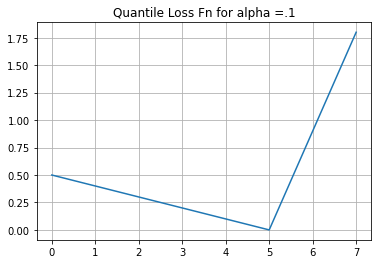

In [18]:
xvals = np.linspace(0,7,71)
plt.plot(xvals, [qlf(5,x,.1) for x in xvals])
plt.grid()
plt.title('Quantile Loss Fn for alpha =.1');

## Idea - it is 9 times worse to be bigger than the true value than to be smaller than the true value (for $\alpha = .1$)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Conformalized Quantile Regression - How it works
 - ### 1) Choose your *coverage* value $c$, 
  ##### e.g. I want to cover the true value 80\% of the time => $c=.8$
 - ### 2) Train two quantile regression models:
 ##### one for the left endpoint ($\alpha_{l} = \frac{1-c}{2}$) (=.1 in this example)
 ##### one for the right endpoint ($\alpha_{r} = 1-\frac{1-c}{2} = 1-\alpha_{l}$). (=.9 in this example) 
 - ### 3) Use this "naive" model to make interval predictions on the calibration set.  Calculate the residuals $Z_i$ on the calibration set as the *distance to the predicted interval*.  
 ##### E.g. if you predict the interval $(20,50)$ and the answer is 15, the residual is 5, if the answer is 70, the residual is 20, if the answer is 40, the distance is 0.
 - ### 4) If your desired coverage is, say, .8, and you have 99 points in your calibration set, choose the 80th biggest residual ($A_{80}$) and widen your interval by that amount.
 - ### 5) In other words, when the "naive" QR model predicts $(b_l, b_r)$, update the prediction interval to be $(b_l-A_{80}, b_r + A_{80}$)
 - ### 6) By the same arguments as before, the (unconditional) probability that a prediction interval contains the true value is $c$ (.8 in this example)
 
 

<br>
<br>
<br>


## Q: Why is this so much better than "regular" Conformal Prediction

## A: Here, the initial intervals are of various sizes, and can reflect the "signal" in the data.  
#### If the data suggests a narrower range for the outcome, the "naive" interval will be narrower
#### (and conversely, for when the data shows a wide range)
### Only the *correction* to the interval is "one size fits all"

In [19]:


# from sklearn.base import RegressorMixin, clone

In [20]:
estimator = lgbm.LGBMRegressor(
    max_depth=8, n_estimators=5000, learning_rate=.02,
    objective='quantile',
    alpha=0.5,
    random_state=random_state
)
estimator.fit(X_train, y_train, eval_set=[(X_calib, y_calib)],
                          callbacks=[lgbm.early_stopping(stopping_rounds=50)])
estimator

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4565]	valid_0's quantile: 1.94689


LGBMRegressor(alpha=0.5, learning_rate=0.02, max_depth=8, n_estimators=5000,
              objective='quantile', random_state=42)

In [21]:
estimator_left = clone(estimator)
estimator_right = clone(estimator)

In [22]:
estimator_left.set_params(**{'alpha':.1})

LGBMRegressor(alpha=0.1, learning_rate=0.02, max_depth=8, n_estimators=5000,
              objective='quantile', random_state=42)

In [23]:
estimator_right.set_params(**{'alpha':.9})

LGBMRegressor(alpha=0.9, learning_rate=0.02, max_depth=8, n_estimators=5000,
              objective='quantile', random_state=42)

In [24]:
estimator_left.fit(X_train, y_train, eval_set=[(X_calib, y_calib)],
                          callbacks=[lgbm.early_stopping(stopping_rounds=50)])
estimator_right.fit(X_train, y_train, eval_set=[(X_calib, y_calib)],
                          callbacks=[lgbm.early_stopping(stopping_rounds=50)])


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1014]	valid_0's quantile: 0.987453
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[398]	valid_0's quantile: 1.26329


LGBMRegressor(alpha=0.9, learning_rate=0.02, max_depth=8, n_estimators=5000,
              objective='quantile', random_state=42)

In [25]:
left_ep_test = estimator_left.predict(X_test)
right_ep_test = estimator_right.predict(X_test)

In [26]:
pis_test_naive = np.vstack((left_ep_test,right_ep_test)).T
pis_test_naive[:4,:], y_test[:4]

(array([[39.24785358, 53.68110439],
        [36.39710509, 50.00755054],
        [34.51932355, 44.12268496],
        [27.66575664, 30.8599686 ]]),
 array([40.26953526, 47.02984744, 45.85429086, 28.02168359]))

In [27]:
coverage_res_naive = (y_test >= pis_test_naive[:,0]) & (y_test<=pis_test_naive[:,1])
np.mean(coverage_res_naive), np.mean(pis_test_naive[:,1]-pis_test_naive[:,0])

(0.5714285714285714, 10.512090620566225)

As you can see, these prediction intervals do not give the promised coverage.  We will now use the calibration set to "correct" these intervals

In [28]:
def interval_residuals(intervals, values):
    left_resid = np.maximum(intervals[:,0]-values,0)
    right_resid = np.maximum(values-intervals[:,1],0)
    return(left_resid+right_resid)

In [29]:
left_ep_calib = estimator_left.predict(X_calib)
right_ep_calib = estimator_right.predict(X_calib)

In [30]:
pis_calib_naive = np.vstack((left_ep_calib,right_ep_calib)).T
pis_calib_naive[:4,:], y_calib[:4]

(array([[57.41632908, 66.01770215],
        [40.52255302, 41.71486098],
        [38.99067064, 48.97467161],
        [33.07778512, 45.30986777]]),
 array([79.98611076, 44.2960751 , 36.44776979, 47.81378165]))

In [31]:
ir_calib = interval_residuals(pis_calib_naive, y_calib)
ir_sorted = np.sort(ir_calib)
num_pts_calib = len(y_calib)
q_val = .8


In [32]:
index_to_use = int(np.ceil(q_val * (num_pts_calib +1))-1)
conformal_adj = ir_sorted[index_to_use]
conformal_adj

2.0089824240783063

In [33]:
pis_test_conformed = np.vstack((pis_test_naive[:,0]-conformal_adj, 
                                  pis_test_naive[:,1]+conformal_adj)).T

In [34]:
pis_test_naive[:4,:]

array([[39.24785358, 53.68110439],
       [36.39710509, 50.00755054],
       [34.51932355, 44.12268496],
       [27.66575664, 30.8599686 ]])

In [35]:
pis_test_conformed[:4,:]

array([[37.23887115, 55.69008681],
       [34.38812266, 52.01653296],
       [32.51034112, 46.13166739],
       [25.65677422, 32.86895102]])

In [36]:

coverage_res_cqr = (y_test >= pis_test_conformed[:,0]) & (y_test<=pis_test_conformed[:,1])
interval_widths_cqr = pis_test_conformed[:,1]-pis_test_conformed[:,0]
np.mean(coverage_res_cqr), np.mean(interval_widths_cqr)

(0.8116883116883117, 14.530055468722834)

In [37]:
np.mean(coverage_res_cqr[y_test<20]), np.mean(coverage_res_cqr[y_test>=60])

(0.7692307692307693, 0.5185185185185185)

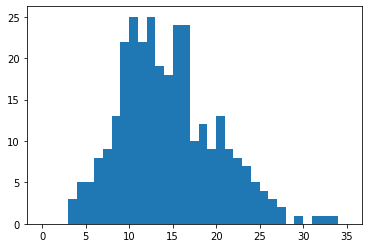

In [38]:
plt.hist(interval_widths_cqr, bins=np.linspace(0,35,36));

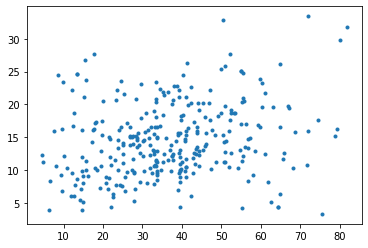

In [39]:
plt.scatter(y_test, interval_widths_cqr, marker='.');

## MAPIE package
The MAPIE package provides some tooling to make this a bit more seamless.  However, its standard usage requires you to use the same parameters (including `n_estimators`) for both quantile regressions.  (There is supposed to be a way to pass in the estimators directly, but I had trouble making it work).  They also force you to provide a point prediction method (which is unnecessary for CQR).  I suspect the package will improve as they get more feedback.

Conformal prediction (as we have seen) is pretty easy to implement, so you can probably do it yourself.  We demonstrate MAPIE for CQR here as a reference

In [40]:
# from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
# from sklearn.datasets import fetch_california_housing
# from scipy.stats import randint, uniform

from mapie.metrics import (
    regression_coverage_score,
    regression_mean_width_score
    )
from mapie.regression import MapieRegressor
from mapie.subsample import Subsample
from mapie.quantile_regression import MapieQuantileRegressor


In [41]:
base_estimator = lgbm.LGBMRegressor(
    max_depth=6, n_estimators=5000, learning_rate=.02,
    objective='quantile',
    alpha=0.5,
    random_state=random_state
)
base_estimator.fit(X_train, y_train, eval_set=[(X_calib, y_calib)],
                          callbacks=[lgbm.early_stopping(stopping_rounds=50)])
base_estimator

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1720]	valid_0's quantile: 1.96701


LGBMRegressor(alpha=0.5, learning_rate=0.02, max_depth=6, n_estimators=5000,
              objective='quantile', random_state=42)

In [42]:
# alpha = 1-coverage
mapie_cqr = MapieQuantileRegressor(estimator=estimator,
                                   method='quantile', alpha=.2)

In [43]:
mapie_cqr.fit(X_train, y_train, X_calib=X_calib, y_calib=y_calib)
y_preds_mapie, y_pis_mapie = mapie_cqr.predict(X_test)

/Users/brianlucena/.pyenv/versions/3.9.13/envs/ds3913/lib/python3.9/site-packages/mapie/utils.py:484: UserWarning: WARNING: The predictions of the quantile regression have issues.
The upper quantile predictions are lower
than the lower quantile predictions
at some points.
  warnings.warn(
/Users/brianlucena/.pyenv/versions/3.9.13/envs/ds3913/lib/python3.9/site-packages/mapie/utils.py:502: UserWarning: WARNING: The predictions have issues.
The upper predictions are lower thanthe lower predictions at some points.
  warnings.warn(


In [44]:
y_preds_mapie[:4]

array([40.49323535, 46.87532782, 41.57919496, 29.80713371])

In [45]:
y_pis_mapie[:4]

array([[[36.81421161],
        [52.37373125]],

       [[35.97281991],
        [52.8519998 ]],

       [[33.61244808],
        [46.52274638]],

       [[24.69915655],
        [32.52504174]]])

In [46]:
y_pis_mapie = y_pis_mapie.reshape((len(y_test),2))
y_pis_mapie[:4,:]

array([[36.81421161, 52.37373125],
       [35.97281991, 52.8519998 ],
       [33.61244808, 46.52274638],
       [24.69915655, 32.52504174]])

In [47]:
coverage_res_mapie = (y_test >= y_pis_mapie[:,0]) & (y_test<=y_pis_mapie[:,1])
np.mean(coverage_res_mapie), np.mean(y_pis_mapie[:,1]-y_pis_mapie[:,0])

(0.8246753246753247, 13.755788597463663)

In [48]:
est_left = clone(base_estimator)
est_right = clone(base_estimator)

In [49]:
est_left.set_params(**{'alpha':.1})

LGBMRegressor(alpha=0.1, learning_rate=0.02, max_depth=6, n_estimators=5000,
              objective='quantile', random_state=42)

In [50]:
est_right.set_params(**{'alpha':.9})

LGBMRegressor(alpha=0.9, learning_rate=0.02, max_depth=6, n_estimators=5000,
              objective='quantile', random_state=42)

In [51]:
est_left.fit(X_train, y_train) # no early stopping - use what base_estimator has
est_right.fit(X_train, y_train) 

LGBMRegressor(alpha=0.9, learning_rate=0.02, max_depth=6, n_estimators=5000,
              objective='quantile', random_state=42)

In [52]:
left_ep_test_pc = est_left.predict(X_test)
right_ep_test_pc = est_right.predict(X_test)

In [53]:
pis_preconformal = np.vstack((left_ep_test_pc,right_ep_test_pc)).T

In [54]:
(y_pis_mapie[:,0] - pis_preconformal[:,0])[:10]

array([-2.99545949, -4.16622748, -3.2711696 , -1.93807947, -2.95614258,
       -4.95604753, -3.03714181, -3.76300653, -2.91932085, -4.57022975])

In [55]:
(y_pis_mapie[:,1] - pis_preconformal[:,1])[:10]

array([1.95915723, 2.81726122, 3.71230112, 2.09554627, 2.31796434,
       3.02997068, 2.50590108, 2.54245918, 1.97409385, 2.97846344])